# Removing losses from rainfall profiles
The rainfall input which is required by the Hec-Ras model is the net rainfall, after losses have been subtracted (this is something to do with Hec-Ras not being able to model losses to infiltration etc). To get this net rainfall the synthetic rainfall profiles are input into ReFH2, antecedent conditions are provided, and a .csv file which includes the rainfall with losses removed is output.

This script plots the rainfall both pre and post loss removal for the two methods of generating synthetic rainfall events. 

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.patches as mpatches
import numpy as np
from datetime import datetime, timedelta

roberto_profiles_fp = "RobertoProfiles/"
multiple_peaks_fp =  "MultiplePeaks/"

## Multiple peaks

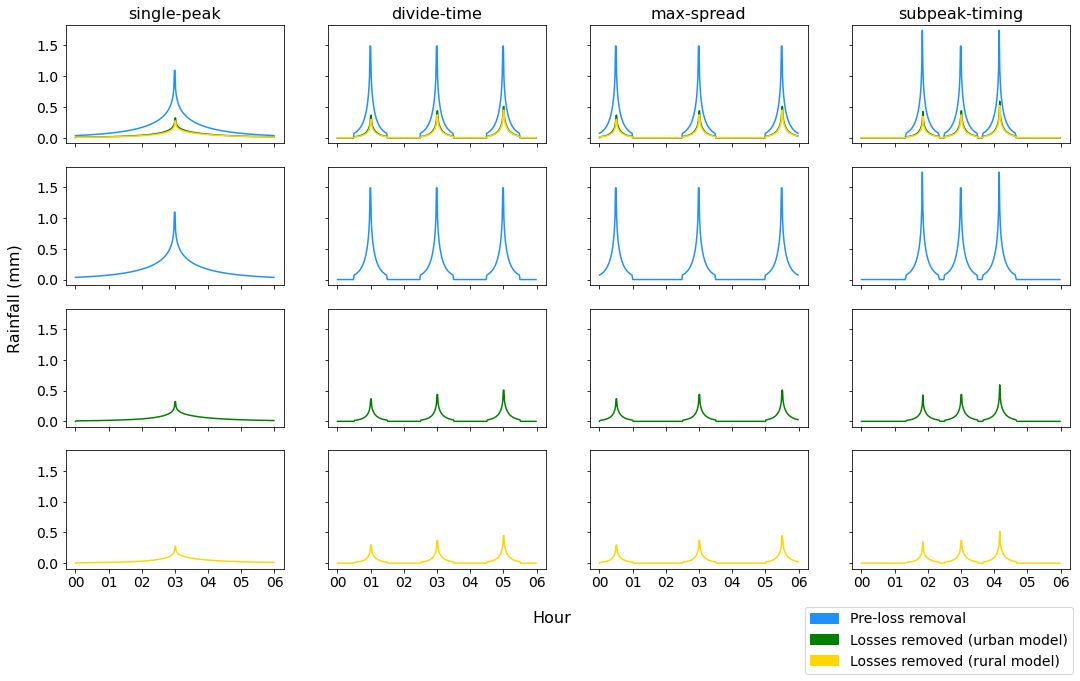

In [24]:
methods=['single-peak','divide-time','max-spread','subpeak-timing']
durations = ['1h', '3h', '6h']

# Set size of x/y tick labels in all subplots
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, axes = plt.subplots(4, len(methods), figsize=(18,10), sharex =True, sharey = True)

# Set title on columns
for ax, col in zip(axes[0], methods):
    ax.set_title(col, size =16)
    
# Read in data
for axes_number, method in enumerate(methods):
    
    pre_loss_removal = pd.read_csv(multiple_peaks_fp + "PreLossRemoval/6h/6h_{}.csv".format(method))
    pre_loss_removal = pre_loss_removal.rename(columns={'2022-04-05 00:00:00': 'Time', '0.0': 'Rainfall'})
    post_loss_removal_urban = pd.read_csv(multiple_peaks_fp + "PostLossRemoval/6h/6h_{}_urban.csv".format(method))
    post_loss_removal_rural = pd.read_csv(multiple_peaks_fp + "PostLossRemoval/6h/6h_{}_rural.csv".format(method))
    
    # Convert date to datetime
    pre_loss_removal['Time'] = pd.to_datetime(pre_loss_removal['Time'])
    post_loss_removal_urban['Time'] = pd.to_datetime(post_loss_removal_urban['Time'])
    post_loss_removal_rural['Time'] = pd.to_datetime(post_loss_removal_rural['Time'])
    
    # Filter to only include those within the first 6 hours
    post_loss_removal_urban = post_loss_removal_urban[(post_loss_removal_urban['Time'] >= '2022-05-04 00:00:00') & (post_loss_removal_urban['Time'] < '2022-05-04 06:00:00')]
    post_loss_removal_rural = post_loss_removal_rural[(post_loss_removal_rural['Time'] >= '2022-05-04 00:00:00') & (post_loss_removal_rural['Time'] < '2022-05-04 06:00:00')]
    
    # Dates are flipped between the two, dates are arbitrary anyway, so just make consistent
    pre_loss_removal['Time'] =  post_loss_removal_rural['Time']
    
    # PLot
    axes[0, axes_number].plot(pre_loss_removal['Time'], pre_loss_removal['Rainfall'], color = 'dodgerblue')
    axes[0, axes_number].plot(post_loss_removal_urban['Time'], post_loss_removal_urban['Total net rain mm (Observed rainfall - 05/04/2022) - urbanised model'], color = 'green')
    axes[0, axes_number].plot(post_loss_removal_rural['Time'], post_loss_removal_rural['Total net rain mm (Observed rainfall - 05/04/2022) - as 100% rural model'], color = 'gold')

    axes[1, axes_number].plot(pre_loss_removal['Time'], pre_loss_removal['Rainfall'], color = 'dodgerblue')
    axes[2, axes_number].plot(post_loss_removal_urban['Time'], post_loss_removal_urban['Total net rain mm (Observed rainfall - 05/04/2022) - urbanised model'], color = 'green')
    axes[3, axes_number].plot(post_loss_removal_rural['Time'], post_loss_removal_rural['Total net rain mm (Observed rainfall - 05/04/2022) - as 100% rural model'], color = 'gold')
   
    myFmt = mdates.DateFormatter('%H')
    axes[3, axes_number].xaxis.set_major_formatter(myFmt)
    
fig.text(0.5, 0.05, 'Hour', ha='center', size =16)
fig.text(0.08, 0.5, 'Rainfall (mm)', va='center', rotation='vertical', size = 16)    

green_patch = mpatches.Patch(color='green', label='Losses removed (urban model)')
blue_patch = mpatches.Patch(color='dodgerblue', label='Pre-loss removal')
gold_patch = mpatches.Patch(color='gold', label='Losses removed (rural model)')
plt.legend(handles=[blue_patch, green_patch, gold_patch], loc="lower center", fontsize= 14, bbox_to_anchor=(0.4, -0.95))

## Roberto profiles 

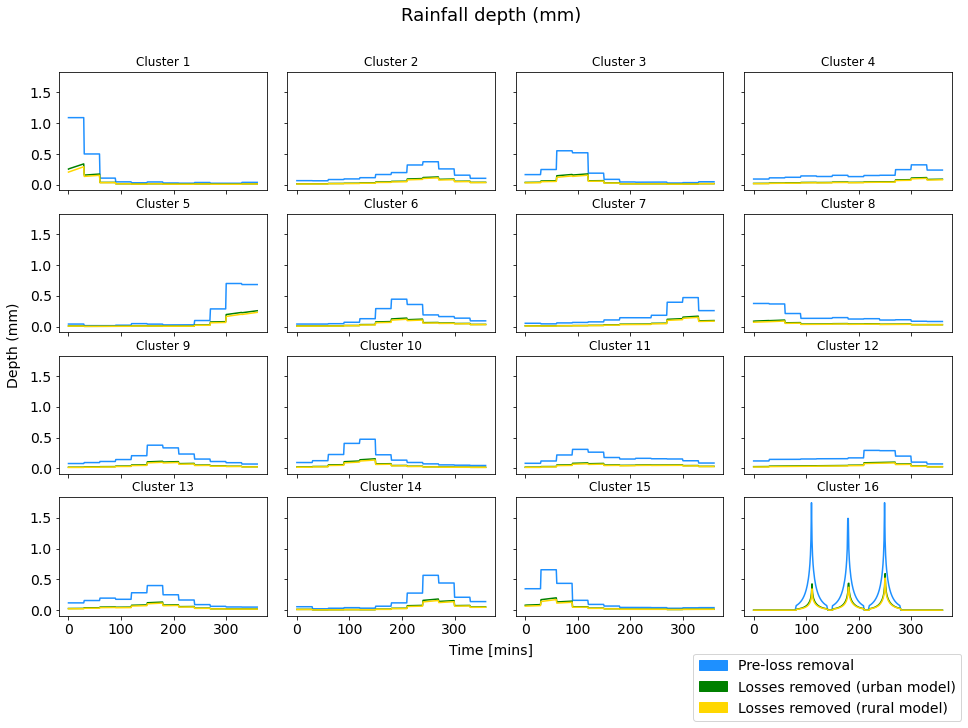

In [101]:
total_duration_minutes = 60* 6 
# Define cluster numbers (one extra for FEH single peak plot)
clusters =[*range(1, 17, 1)]

# Plot
fig, axs = plt.subplots(nrows=4, ncols=4, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.97)
      
# loop through tickers and axes
for axes_number, cluster_num in enumerate(clusters):
    if cluster_num == 16:
            pre_loss_removal = pd.read_csv(multiple_peaks_fp + "PreLossRemoval/6h/6h_{}.csv".format(method))
            pre_loss_removal = pre_loss_removal.rename(columns={'2022-04-05 00:00:00': 'Time', '0.0': 'Rainfall'})
            post_loss_removal_urban = pd.read_csv(multiple_peaks_fp + "PostLossRemoval/6h/6h_{}_urban.csv".format(method))
            post_loss_removal_rural = pd.read_csv(multiple_peaks_fp + "PostLossRemoval/6h/6h_{}_rural.csv".format(method))
    else:
        pre_loss_removal = pd.read_csv(roberto_profiles_fp + "PreLossRemoval/6hr_100yrRP/cluster{}.csv".format(cluster_num), names = ['Time', 'Rainfall'])
        post_loss_removal_urban = pd.read_csv(roberto_profiles_fp + "PostLossRemoval/6hr_100yrRP/cluster{}_urban.csv".format(cluster_num))
        post_loss_removal_rural = pd.read_csv(roberto_profiles_fp + "PostLossRemoval/6hr_100yrRP/cluster{}_rural.csv".format(cluster_num))

    ax = axs.ravel()[cluster_num-1]
    
    # Convert date to datetime
    pre_loss_removal['Time'] = pd.to_datetime(pre_loss_removal['Time'])
    post_loss_removal_urban['Time'] = pd.to_datetime(post_loss_removal_urban['Time'])
    post_loss_removal_rural['Time'] = pd.to_datetime(post_loss_removal_rural['Time'])

    # Filter to only include those within the first 6 hours
    start_time = post_loss_removal_urban['Time'].loc[0]
    end_time = start_time + timedelta(hours=6) - timedelta(minutes=1)
    post_loss_removal_urban = post_loss_removal_urban[(post_loss_removal_urban['Time'] >= start_time) & (post_loss_removal_urban['Time'] <= end_time)]
    post_loss_removal_rural = post_loss_removal_rural[(post_loss_removal_rural['Time'] >= start_time) & (post_loss_removal_rural['Time'] <= end_time)]

    # Dates are flipped between the two, dates are arbitrary anyway, so just make consistent
    pre_loss_removal['Time'] =  np.array(range(total_duration_minutes))
    post_loss_removal_urban['Time'] =  np.array(range(total_duration_minutes))    
    post_loss_removal_rural['Time'] =  np.array(range(total_duration_minutes)) 
    
    ax.plot(pre_loss_removal['Time'], pre_loss_removal['Rainfall'], color = 'dodgerblue')
    ax.plot(post_loss_removal_urban['Time'], post_loss_removal_urban[post_loss_removal_urban.columns[5]], color = 'green')
    ax.plot(post_loss_removal_rural['Time'], post_loss_removal_rural[post_loss_removal_rural.columns[5]], color = 'gold')
    
    # Add plot subtitles
    if cluster_num == 0:
        ax.set_title("FEH profile")
    else:
        ax.set_title("Cluster {}".format(cluster_num))
        
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.08, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14)

# Legend
green_patch = mpatches.Patch(color='green', label='Losses removed (urban model)')
blue_patch = mpatches.Patch(color='dodgerblue', label='Pre-loss removal')
gold_patch = mpatches.Patch(color='gold', label='Losses removed (rural model)')
plt.legend(handles=[blue_patch, green_patch, gold_patch], loc="lower center", fontsize= 14, bbox_to_anchor=(0.4, -0.95))